# Importing libraries

In [ ]:
!pip install torch torchvision

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import time
from collections import defaultdict

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from PIL import Image
from torchvision import transforms
import os
from torchvision import transforms

In [6]:
import random
import time

In [7]:
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
import shutil
import os
from google.colab import drive

# CNN

In [47]:
class SixLayerCNN(nn.Module):
    def __init__(self, num_channels=3, embedding_dim=64):
        super(SixLayerCNN, self).__init__()

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(32*3*3, embedding_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [48]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        #
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            out = self.encoder(dummy)
            self.flat_dim = out.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flat_dim, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [49]:
model = SixLayerCNN()
print(model)

SixLayerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# Importing dataset

In [50]:
drive.mount('/content/drive')
file_path='/content/drive/My Drive/Machine Vision'
!ls '/content/drive/My Drive/Machine Vision/Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset_analysis	   mnistDataset      mnistFO_preprocessed
implementation_meta.ipynb  mnistDataset.zip  mnistOrg
meta_model_final.pth	   mnistFO	     organized_dataset


In [51]:
!ls '/content/drive/My Drive/Machine Vision/Project/mnistFO'

 abdomen   chest   foot     'lower extremity'   trunk
 acral	   ear	   genital   neck	        unknown
 back	   face    hand      scalp	       'upper extremity'


In [52]:
destination = '/content/drive/My Drive/Machine Vision/Project/mnistDataset'
# os.makedirs(destination, exist_ok=True)

In [53]:
metadata_df = pd.read_csv(destination+"/HAM10000_metadata.csv")

print(metadata_df['dx'].value_counts(normalize=False))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [54]:
metadata_df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [87]:
metadata_df[metadata_df['localization'] =='hand']

,lesion_id,image_id,dx,dx_type,age,sex,localization
277,HAM_0000113,ISIC_0029548,bkl,histo,75.0,female,hand
278,HAM_0000113,ISIC_0027989,bkl,histo,75.0,female,hand
285,HAM_0002691,ISIC_0031345,bkl,histo,80.0,female,hand
324,HAM_0001435,ISIC_0028970,bkl,histo,65.0,female,hand
379,HAM_0003913,ISIC_0027295,bkl,histo,60.0,male,hand
...,...,...,...,...,...,...,...
9920,HAM_0006442,ISIC_0033295,akiec,histo,70.0,male,hand
9961,HAM_0001023,ISIC_0026468,akiec,histo,50.0,male,hand
9973,HAM_0007008,ISIC_0030036,akiec,histo,60.0,male,hand
9977,HAM_0006902,ISIC_0031506,akiec,histo,70.0,male,hand


In [88]:
localization = 'scalp'
dpl = metadata_df[metadata_df['localization']==localization]

print(dpl['dx'].value_counts(normalize=False))

dx
nv       45
bkl      34
bcc      19
mel      14
akiec    14
vasc      2
Name: count, dtype: int64


In [89]:
metadata_df = pd.read_csv(destination+"/HAM10000_metadata.csv")
metadata_df.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp


In [90]:
DATA_ROOT = "/content/drive/My Drive/Machine Vision/Project/mnistFO"

In [91]:
!ls "/content/drive/My Drive/Machine Vision/Project/mnistFO"

 abdomen   chest   foot     'lower extremity'   trunk
 acral	   ear	   genital   neck	        unknown
 back	   face    hand      scalp	       'upper extremity'


In [92]:
train_diseases = ['nv', 'bkl', 'mel', 'bcc']
test_diseases  = ['akiec', 'vasc']

train_locations = [
 'scalp','ear','face','back','trunk','chest',
 'abdomen','hand','upper extremity',
 'neck','foot','acral','genital','unknown','lower extremity'
]

test_locations = ['abdomen','hand','upper extremity']

N_WAY = 2
K_SHOT = 3
QUERY = 2
IMG_SIZE = 224



In [61]:
# !cp -r "/content/drive/My Drive/MachineVision/Project/mnistFO" /content/

In [93]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [94]:
def build_image_cache(data_root, transform):

    image_cache = {}

    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path):
            continue

        image_cache[location] = {}

        for disease in os.listdir(loc_path):
            disease_path = os.path.join(loc_path, disease)
            if not os.path.isdir(disease_path):
                continue

            image_cache[location][disease] = []

            for fname in os.listdir(disease_path):
                img_path = os.path.join(disease_path, fname)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img_tensor = transform(img)
                    image_cache[location][disease].append(img_tensor)
                except Exception as e:
                    print("Problem with:", img_path, e)

    print("✅ Image cache ready")
    print("Locations:", list(image_cache.keys())[:5])
    return image_cache


In [95]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=10),
    transforms.ToTensor()
])

In [96]:
transform_eval = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [97]:
def build_cache(data_root, transform):
    cache = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path):
            continue

        cache[location] = {}
        for disease in os.listdir(loc_path):
            dpath = os.path.join(loc_path, disease)
            if not os.path.isdir(dpath):
                continue

            cache[location][disease] = []
            for fname in os.listdir(dpath):
                img = Image.open(os.path.join(dpath, fname)).convert("RGB")
                cache[location][disease].append(transform(img))
    return cache


In [67]:
!mkdir "/content/mnistFO/train"

mkdir: cannot create directory ‘/content/mnistFO/train’: No such file or directory


In [68]:
!mkdir "/content/mnistFO/eval"

mkdir: cannot create directory ‘/content/mnistFO/eval’: No such file or directory


In [69]:
!mkdir "/content/imageCache"
for localization in metadata_df['localization'].unique():
  !mkdir "/content/imageCache/{localization}"

In [70]:
!ls "/content/imageCache"

 abdomen   chest   foot     'lower extremity'   trunk
 acral	   ear	   genital   neck	        unknown
 back	   face    hand      scalp	       'upper extremity'


In [98]:
def build_image_cache(data_root, diseases, locations, transform):

    cache = {}
    total_images = 0

    print(f"🔄 Building image cache from {data_root}...")

    for location in locations:
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path):
            print(f"⚠️ Missing location: {location}")
            continue

        cache[location] = {}

        for disease in diseases:
            disease_path = os.path.join(loc_path, disease)
            if not os.path.isdir(disease_path):
                continue

            cache[location][disease] = []

            for fname in os.listdir(disease_path):
                if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                    continue

                img_path = os.path.join(disease_path, fname)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img_tensor = transform(img)
                    cache[location][disease].append(img_tensor)
                    total_images += 1
                except Exception as e:
                    print(f"❌ Error loading {img_path}: {e}")

            if len(cache[location][disease]) > 0:
                print(f"  ✓ {location}/{disease}: {len(cache[location][disease])} images")

    print(f"✅ Cache ready! Total images: {total_images}")
    return cache

# Dataset indexing

In [34]:
def build_index(root):
    index = {}  # index[location][disease] = [paths]

    for loc in os.listdir(root):
        loc_path = os.path.join(root, loc)
        if not os.path.isdir(loc_path):
            continue

        index[loc] = {}

        for dis in os.listdir(loc_path):
            dis_path = os.path.join(loc_path, dis)
            if not os.path.isdir(dis_path):
                continue

            images = [
                os.path.join(dis_path, f)
                for f in os.listdir(dis_path)
                if f.lower().endswith(('.jpg','.png','.jpeg'))
            ]

            if len(images) > 0:
                index[loc][dis] = images

    return index


data_index = build_index(DATA_ROOT)
print("Locations:", len(data_index))


Locations: 15


In [35]:
len(metadata_df['localization'].unique())

15

In [36]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# # Loader for images

In [72]:
def load_images(paths):
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        imgs.append(transform(img))
    return torch.stack(imgs)


# Episode Sampler

In [99]:
!ls "/content/imageCache"

 abdomen   chest   foot     'lower extremity'   trunk
 acral	   ear	   genital   neck	        unknown
 back	   face    hand      scalp	       'upper extremity'


In [100]:
!ls "/content/imageCache/chest"

In [101]:
def can_sample(diseases, location, cache):
    if location not in cache:
        return False
    for disease in diseases:
        if disease not in cache[location]:
            return False
        if len(cache[location][disease]) < K_SHOT + QUERY:
            return False
    return True


In [102]:
def sample_episode_cached(cache, diseases, locations):
    max_attempts = 100
    for _ in range(max_attempts):
        chosen_diseases = random.sample(diseases, N_WAY)
        location = random.choice(locations)

        if can_sample(chosen_diseases, location, cache):
            break
    else:
        raise ValueError("Cannot find the valid combination")

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    for label, disease in enumerate(chosen_diseases):
        imgs = random.sample(cache[location][disease], K_SHOT + QUERY)

        support_images.extend(imgs[:K_SHOT])
        support_labels.extend([label]*K_SHOT)

        query_images.extend(imgs[K_SHOT:])
        query_labels.extend([label]*QUERY)

    return (
        torch.stack(support_images),
        torch.tensor(support_labels),
        torch.stack(query_images),
        torch.tensor(query_labels)
    )




# Prototypical loss

In [103]:
def prototypical_loss(support_emb, support_labels, query_emb, query_labels):
    """Prototypical Networks loss"""
    prototypes = []
    for c in range(N_WAY):
        mask = support_labels == c
        prototypes.append(support_emb[mask].mean(0))

    prototypes = torch.stack(prototypes)
    dists = torch.cdist(query_emb, prototypes)

    loss = F.cross_entropy(-dists, query_labels)
    preds = torch.argmin(dists, dim=1)
    acc = (preds == query_labels).float().mean()

    return loss, acc

In [104]:
def evaluate(model, cache, diseases, locations, num_episodes=50):
    """Ispravljena evaluate funkcija sa debug info"""

    print(f"\n🔍 Evaluating sa:")
    print(f"  Diseases: {diseases}")
    print(f"  Locations: {locations}")

    model.eval()
    total_acc = 0
    total_loss = 0
    valid_episodes = 0
    failed_attempts = 0

    with torch.no_grad():
        for ep in range(num_episodes):
            try:
                s_imgs, s_lbls, q_imgs, q_lbls = sample_episode_cached(
                    cache, diseases, locations
                )

                s_emb = model(s_imgs)
                q_emb = model(q_imgs)

                loss, acc = prototypical_loss(s_emb, s_lbls, q_emb, q_lbls)

                total_acc += acc.item()
                total_loss += loss.item()
                valid_episodes += 1

            except ValueError as e:
                failed_attempts += 1
                if failed_attempts <= 5:  # Prikaži prvih 5 grešaka
                    print(f"  ⚠️  Episode {ep} failed: {e}")
                continue

    print(f"\n  Valid episodes: {valid_episodes}/{num_episodes}")
    print(f"  Failed: {failed_attempts}")

    if valid_episodes == 0:
        print("  ❌ NEMA VALIDNIH EPIZODA!")
        return 0.0, 0.0

    return total_loss / valid_episodes, total_acc / valid_episodes


# check size of test set

In [105]:
import os
from collections import defaultdict

def count_images_from_drive(data_root, diseases, locations):

    stats = defaultdict(lambda: defaultdict(int))

    for loc in locations:
        loc_path = os.path.join(data_root, loc)

        if not os.path.isdir(loc_path):
            continue

        for dis in diseases:
            dis_path = os.path.join(loc_path, dis)

            if not os.path.isdir(dis_path):
                continue

            # Broji sve image fileove
            image_files = [
                f for f in os.listdir(dis_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            stats[loc][dis] = len(image_files)

    return stats



DATA_ROOT = "/content/drive/My Drive/Machine Vision/Project/mnistFO"

# Definiraj setove
# train_diseases = ['akiec', 'vasc']
test_diseases = ['akiec', 'vasc']

#train_locations = ['abdomen', 'hand', 'upper extremity']
test_locations = ['abdomen', 'hand', 'upper extremity']

K_SHOT = 3
QUERY = 2
REQUIRED = K_SHOT + QUERY

print("\n📊 TEST SET STATISTICS (from Drive):")
print(f"Test diseases: {test_diseases}")
print(f"Test locations: {test_locations}")
print(f"Required per disease: {REQUIRED} images")
print("\n" + "="*60)

# Broji direktno sa diska
test_stats = count_images_from_drive(DATA_ROOT, test_diseases, test_locations)

# Print rezultate
print("\nAvailable samples:")
for loc in test_locations:
    if loc in test_stats:
        for dis in test_diseases:
            if dis in test_stats[loc]:
                count = test_stats[loc][dis]
                status = "✅" if count >= REQUIRED else "❌"
                print(f"{status} {loc}/{dis}: {count} images (need {REQUIRED})")
            else:
                print(f"❌ {loc}/{dis}: MISSING (folder doesn't exist)")
    else:
        print(f"❌ {loc}: LOCATION MISSING (folder doesn't exist)")

# Bonus: Provjeri i TRAIN set
print("\n" + "="*60)
print("📊 TRAIN SET STATISTICS (from Drive):")
train_stats = count_images_from_drive(DATA_ROOT, train_diseases, train_locations)

print("\nAvailable samples:")
for loc in train_locations:
    if loc in train_stats:
        for dis in train_diseases:
            if dis in train_stats[loc]:
                count = train_stats[loc][dis]
                status = "✅" if count >= REQUIRED else "❌"
                print(f"{status} {loc}/{dis}: {count} images (need {REQUIRED})")
            else:
                print(f"❌ {loc}/{dis}: MISSING")
    else:
        print(f"❌ {loc}: LOCATION MISSING")

# Summary
print("\n" + "="*60)
print("📋 SUMMARY:")

valid_test_combos = sum(
    1 for loc in test_locations
    for dis in test_diseases
    if loc in test_stats and dis in test_stats[loc] and test_stats[loc][dis] >= REQUIRED
)

valid_train_combos = sum(
    1 for loc in train_locations
    for dis in train_diseases
    if loc in train_stats and dis in train_stats[loc] and train_stats[loc][dis] >= REQUIRED
)

total_test = len(test_locations) * len(test_diseases)
total_train = len(train_locations) * len(train_diseases)

print(f"✅ Valid TEST combinations: {valid_test_combos}/{total_test}")
print(f"✅ Valid TRAIN combinations: {valid_train_combos}/{total_train}")

if valid_test_combos == 0:
    print("\n⚠️  PROBLEM: Nema validnih test kombinacija!")
    print("Moguća rješenja:")
    print(f"  1. Smanji K_SHOT i QUERY (trenutno {K_SHOT}+{QUERY}={REQUIRED})")
    print(f"  2. Promijeni test_diseases ili test_locations")
    print(f"  3. Provjeri strukturu foldera na {DATA_ROOT}")


📊 TEST SET STATISTICS (from Drive):
Test diseases: ['akiec', 'vasc']
Test locations: ['abdomen', 'hand', 'upper extremity']
Required per disease: 5 images


Available samples:
✅ abdomen/akiec: 5 images (need 5)
✅ abdomen/vasc: 27 images (need 5)
✅ hand/akiec: 13 images (need 5)
✅ hand/vasc: 5 images (need 5)
✅ upper extremity/akiec: 62 images (need 5)
✅ upper extremity/vasc: 11 images (need 5)

📊 TRAIN SET STATISTICS (from Drive):

Available samples:
✅ scalp/nv: 45 images (need 5)
✅ scalp/bkl: 34 images (need 5)
✅ scalp/mel: 14 images (need 5)
✅ scalp/bcc: 19 images (need 5)
✅ ear/nv: 30 images (need 5)
✅ ear/bkl: 6 images (need 5)
✅ ear/mel: 17 images (need 5)
❌ ear/bcc: 0 images (need 5)
✅ face/nv: 100 images (need 5)
✅ face/bkl: 319 images (need 5)
✅ face/mel: 104 images (need 5)
✅ face/bcc: 101 images (need 5)
✅ back/nv: 1427 images (need 5)
✅ back/bkl: 202 images (need 5)
✅ back/mel: 324 images (need 5)
✅ back/bcc: 186 images (need 5)
✅ trunk/nv: 1241 images (need 5)
✅ trunk/bkl:

# Tranining

In [106]:
model = SimpleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [107]:
train_cache = build_image_cache(
    DATA_ROOT,
    train_diseases,
    train_locations,
    transform_train
)

# Build test cache
test_cache = build_image_cache(
    DATA_ROOT,
    test_diseases,
    test_locations,
    transform_eval
)


🔄 Building image cache from /content/drive/My Drive/Machine Vision/Project/mnistFO...
  ✓ scalp/nv: 45 images
  ✓ scalp/bkl: 34 images
  ✓ scalp/mel: 14 images
  ✓ scalp/bcc: 19 images
  ✓ ear/nv: 30 images
  ✓ ear/bkl: 6 images
  ✓ ear/mel: 17 images
  ✓ face/nv: 100 images
  ✓ face/bkl: 319 images
  ✓ face/mel: 104 images
  ✓ face/bcc: 101 images
  ✓ back/nv: 1427 images
  ✓ back/bkl: 202 images
  ✓ back/mel: 324 images
  ✓ back/bcc: 186 images
  ✓ trunk/nv: 1241 images
  ✓ trunk/bkl: 73 images
  ✓ trunk/mel: 47 images
  ✓ trunk/bcc: 11 images
  ✓ chest/nv: 200 images
  ✓ chest/bkl: 74 images
  ✓ chest/mel: 68 images
  ✓ chest/bcc: 47 images
  ✓ abdomen/nv: 860 images
  ✓ abdomen/bkl: 42 images
  ✓ abdomen/mel: 66 images
  ✓ abdomen/bcc: 18 images
  ✓ hand/nv: 55 images
  ✓ hand/bkl: 14 images
  ✓ hand/mel: 1 images
  ✓ hand/bcc: 2 images
  ✓ upper extremity/nv: 655 images
  ✓ upper extremity/bkl: 104 images
  ✓ upper extremity/mel: 213 images
  ✓ upper extremity/bcc: 49 images
  ✓ n

In [108]:
for loc in train_cache:
    for dis in train_cache[loc]:
        print(f"{loc}/{dis}: {len(train_cache[loc][dis])} images")


scalp/nv: 45 images
scalp/bkl: 34 images
scalp/mel: 14 images
scalp/bcc: 19 images
ear/nv: 30 images
ear/bkl: 6 images
ear/mel: 17 images
ear/bcc: 0 images
face/nv: 100 images
face/bkl: 319 images
face/mel: 104 images
face/bcc: 101 images
back/nv: 1427 images
back/bkl: 202 images
back/mel: 324 images
back/bcc: 186 images
trunk/nv: 1241 images
trunk/bkl: 73 images
trunk/mel: 47 images
trunk/bcc: 11 images
chest/nv: 200 images
chest/bkl: 74 images
chest/mel: 68 images
chest/bcc: 47 images
abdomen/nv: 860 images
abdomen/bkl: 42 images
abdomen/mel: 66 images
abdomen/bcc: 18 images
hand/nv: 55 images
hand/bkl: 14 images
hand/mel: 1 images
hand/bcc: 2 images
upper extremity/nv: 655 images
upper extremity/bkl: 104 images
upper extremity/mel: 213 images
upper extremity/bcc: 49 images
neck/nv: 81 images
neck/bkl: 31 images
neck/mel: 29 images
neck/bcc: 14 images
foot/nv: 284 images
foot/bkl: 1 images
foot/mel: 28 images
foot/bcc: 4 images
acral/nv: 7 images
acral/bkl: 0 images
acral/mel: 0 imag

In [109]:
loc = list(train_cache.keys())[0]
dis = list(train_cache[loc].keys())[0]

img = train_cache[loc][dis][0]

print(type(img))
print(img.shape)
print(img.min().item(), img.max().item())


<class 'torch.Tensor'>
torch.Size([3, 128, 128])
0.125490203499794 0.8039215803146362


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

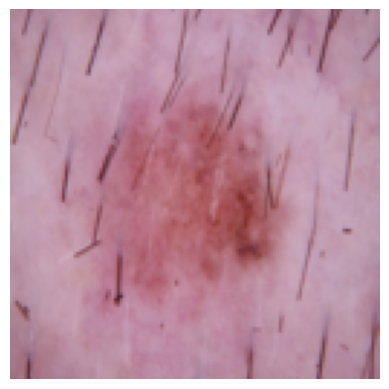

In [110]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.axis("off")


In [111]:
IMG_SIZE = 128
print(model.flat_dim)


100352


In [112]:
EPOCHS = 20
EPISODES_PER_EPOCH = 100

model = SimpleCNN(embedding_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_acc = 0
save_path = "/content/drive/My Drive/MachineVision/Project/meta_model_best.pth"

print("\n" + "="*60)
print("STARTING TRAINING...")
print("="*60)

for epoch in range(EPOCHS):
    model.train()
    total_acc = 0
    total_loss = 0
    start_time = time.time()

    for episode in range(EPISODES_PER_EPOCH):

        s_imgs, s_lbls, q_imgs, q_lbls = sample_episode_cached(
            train_cache, train_diseases, train_locations
        )

        s_emb = model(s_imgs)
        q_emb = model(q_imgs)

        loss, acc = prototypical_loss(s_emb, s_lbls, q_emb, q_lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_acc += acc.item()
        total_loss += loss.item()

        if (episode + 1) % 20 == 0:
            elapsed = time.time() - start_time
            speed = elapsed / (episode + 1)
            eta = speed * (EPISODES_PER_EPOCH - episode - 1)

            print(f"Ep {episode+1}/{EPISODES_PER_EPOCH} | "
                  f"loss={loss.item():.3f} acc={acc.item():.3f} | "
                  f"{speed:.2f}s/ep | ETA {eta/60:.1f} min")

    avg_acc = total_acc / EPISODES_PER_EPOCH
    avg_loss = total_loss / EPISODES_PER_EPOCH

    test_loss, test_acc = evaluate(model, test_cache, test_diseases, test_locations)

    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train loss: {avg_loss:.4f} | Train acc: {avg_acc:.4f}")
    print(f"Test  loss: {test_loss:.4f} | Test  acc: {test_acc:.4f}")
    print("="*50)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_path)
        print("💾 Best model saved!")



STARTING TRAINING...
Ep 20/100 | loss=0.758 acc=0.250 | 0.51s/ep | ETA 0.7 min
Ep 40/100 | loss=1.192 acc=0.500 | 0.44s/ep | ETA 0.4 min
Ep 60/100 | loss=0.719 acc=0.250 | 0.44s/ep | ETA 0.3 min
Ep 80/100 | loss=1.069 acc=0.500 | 0.50s/ep | ETA 0.2 min
Ep 100/100 | loss=0.641 acc=1.000 | 0.48s/ep | ETA 0.0 min

🔍 Evaluating sa:
  Diseases: ['akiec', 'vasc']
  Locations: ['abdomen', 'hand', 'upper extremity']

  Valid episodes: 50/50
  Failed: 0

Epoch 1/20
Train loss: 0.6960 | Train acc: 0.5800
Test  loss: 0.6912 | Test  acc: 0.5500
💾 Best model saved!
Ep 20/100 | loss=0.764 acc=0.500 | 0.42s/ep | ETA 0.6 min
Ep 40/100 | loss=0.683 acc=0.750 | 0.42s/ep | ETA 0.4 min
Ep 60/100 | loss=0.598 acc=0.750 | 0.43s/ep | ETA 0.3 min
Ep 80/100 | loss=0.649 acc=1.000 | 0.41s/ep | ETA 0.1 min
Ep 100/100 | loss=0.659 acc=0.500 | 0.42s/ep | ETA 0.0 min

🔍 Evaluating sa:
  Diseases: ['akiec', 'vasc']
  Locations: ['abdomen', 'hand', 'upper extremity']

  Valid episodes: 50/50
  Failed: 0

Epoch 2/20


In [ ]:
current_model_path = "/content/drive/My Drive/MachineVision/Project/meta_model_final.pth"
torch.save(model.state_dict(), current_model_path)
print(f"💾 Model saved: {current_model_path}")

# Meta-test (akiec, vasc)

In [123]:
"""
JEDNOSTAVAN META-TEST SA SVIM PROVJERAMA
==========================================
Testiranje few-shot modela na novim bolestima
"""

import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import time

# =============================================================================
# KONFIGURACIJA - POSTAVI SVOJE VRIJEDNOSTI
# =============================================================================

class Config:
    # Putanje
    DATA_ROOT = "/content/drive/My Drive/MachineVision/Project/mnistFO"
    MODEL_PATH = "/content/drive/My Drive/MachineVision/Project/meta_model_final.pth"

    # Meta-learning setup (IMG_SIZE će biti detektovan automatski)
    IMG_SIZE = None  # Popuniće se automatski
    N_WAY = 2
    K_SHOT = 3
    QUERY = 2
    EMBEDDING_DIM = 128

    # Test setup
    TEST_DISEASES = ['akiec', 'vasc']
    TEST_LOCATIONS = ['abdomen', 'hand', 'upper extremity']

    NUM_TEST_EPISODES = 100

# =============================================================================
# 1. MODEL (SimpleCNN)
# =============================================================================

class SimpleCNN(nn.Module):
    """Isti model kao za trening"""

    def __init__(self, embedding_dim=128, img_size=224):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Automatski izračun flat_dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            out = self.encoder(dummy)
            self.flat_dim = out.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flat_dim, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# =============================================================================
# DETEKCIJA IMG_SIZE IZ CHECKPOINTA
# =============================================================================

def detect_img_size_from_checkpoint(model_path):
    """Detektuj sa kojim IMG_SIZE je model treniran"""
    checkpoint = torch.load(model_path, map_location='cpu')

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint

    # fc.weight shape: [embedding_dim, flat_dim]
    fc_weight_shape = state_dict['fc.weight'].shape
    flat_dim = fc_weight_shape[1]

    # flat_dim = 128 * (img_size // 8)^2
    # Reši za img_size
    feature_map_size = int((flat_dim / 128) ** 0.5)
    img_size = feature_map_size * 8

    return img_size

# =============================================================================
# 2. PROVJERA STRUKTURE PODATAKA
# =============================================================================

def check_data_structure(data_root, diseases, locations):
    """
    Provjeri da li postoje potrebni folderi i slike
    """
    print("\n" + "="*70)
    print("PROVJERA STRUKTURE PODATAKA")
    print("="*70)

    print(f"\n📂 Data root: {data_root}")
    print(f"🔬 Test diseases: {diseases}")
    print(f"📍 Test locations: {locations}")

    issues = []
    stats = {}

    for location in locations:
        loc_path = os.path.join(data_root, location)

        if not os.path.isdir(loc_path):
            issues.append(f"❌ Folder ne postoji: {location}")
            continue

        stats[location] = {}

        for disease in diseases:
            dis_path = os.path.join(loc_path, disease)

            if not os.path.isdir(dis_path):
                issues.append(f"❌ Folder ne postoji: {location}/{disease}")
                continue

            # Broj slika
            images = [f for f in os.listdir(dis_path)
                     if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            count = len(images)
            stats[location][disease] = count

            min_needed = Config.K_SHOT + Config.QUERY

            if count < min_needed:
                issues.append(f"⚠️  {location}/{disease}: samo {count} slika (treba {min_needed})")
            else:
                print(f"  ✅ {location:20s}/{disease:6s}: {count:4d} slika")

    # Ispis problema
    if issues:
        print(f"\n⚠️  found {len(issues)} PROBLEMA:")
        for issue in issues:
            print(f"  {issue}")
        return False, stats
    else:
        print(f"\n✅ all combinations have enugh information!")
        return True, stats

# =============================================================================
# 3. UČITAVANJE SLIKA U CACHE
# =============================================================================

def build_test_cache(data_root, diseases, locations, img_size):
    """
    Učitaj sve test slike u RAM
    """
    print("\n" + "="*70)
    print("UČITAVANJE TEST SLIKA U CACHE")
    print("="*70)

    print(f"\n📐 Koristim IMG_SIZE = {img_size}")

    # Transformacija (samo resize + normalize, BEZ augmentacije)
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    cache = {}
    total_images = 0

    print(f"\n🔄 Učitavam slike...")

    for location in locations:
        loc_path = os.path.join(data_root, location)

        if not os.path.isdir(loc_path):
            continue

        cache[location] = {}

        for disease in diseases:
            dis_path = os.path.join(loc_path, disease)

            if not os.path.isdir(dis_path):
                continue

            cache[location][disease] = []

            for fname in os.listdir(dis_path):
                if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                    continue

                img_path = os.path.join(dis_path, fname)

                try:
                    img = Image.open(img_path).convert('RGB')
                    tensor = transform(img)
                    cache[location][disease].append(tensor)
                    total_images += 1
                except Exception as e:
                    print(f"  ⚠️  Greška: {img_path} - {e}")

            if len(cache[location][disease]) > 0:
                print(f"  ✅ {location}/{disease}: {len(cache[location][disease])} slika")

    print(f"\n✅ Cache učitan! Ukupno: {total_images} slika")

    return cache

# =============================================================================
# 4. VALIDNE KOMBINACIJE ZA META-TEST
# =============================================================================

def find_valid_combinations(cache, diseases, locations, n_way, k_shot, query):
    """
    Nađi sve validne kombinacije za meta-test epizode
    """
    print("\n" + "="*70)
    print("TRAŽIM VALIDNE KOMBINACIJE")
    print("="*70)

    from itertools import combinations

    valid_combos = []
    min_needed = k_shot + query

    print(f"\n⚙️  Setup: {n_way}-way {k_shot}-shot, {query} query")
    print(f"   Minimum slika po bolesti: {min_needed}")

    # Sve moguće kombinacije bolesti
    disease_combos = list(combinations(diseases, n_way))

    print(f"\n🔬 Moguće kombinacije bolesti: {len(disease_combos)}")
    for combo in disease_combos:
        print(f"   - {combo}")

    # Provjeri svaku kombinaciju sa svakom lokacijom
    for location in locations:
        if location not in cache:
            continue

        for disease_combo in disease_combos:
            # Provjeri da li sve bolesti imaju dovoljno slika
            valid = True
            for disease in disease_combo:
                if disease not in cache[location]:
                    valid = False
                    break
                if len(cache[location][disease]) < min_needed:
                    valid = False
                    break

            if valid:
                valid_combos.append((disease_combo, location))

    print(f"\n✅ Pronađeno {len(valid_combos)} validnih kombinacija:")

    # Grupiši po lokacijama
    by_location = defaultdict(list)
    for diseases_combo, loc in valid_combos:
        by_location[loc].append(diseases_combo)

    for loc in sorted(by_location.keys()):
        print(f"\n  📍 {loc}: {len(by_location[loc])} kombinacija")
        for combo in by_location[loc]:
            counts = [len(cache[loc][d]) for d in combo]
            print(f"     {combo} → slike: {counts}")

    if len(valid_combos) == 0:
        print("\n❌ NEMA VALIDNIH KOMBINACIJA!")
        print("\nMoguci razlozi:")
        print("  1. Premalo slika po bolesti")
        print("  2. Pogrešne bolesti ili lokacije")
        return []

    return valid_combos

# =============================================================================
# 5. META-TEST FUNKCIJA
# =============================================================================

def meta_test(model, cache, valid_combos, n_way, k_shot, query, num_episodes=100):
    """
    Glavni meta-test
    """
    print("\n" + "="*70)
    print("META-TEST EVALUACIJA")
    print("="*70)

    print(f"\n⚙️  Setup:")
    print(f"   Broj epizoda: {num_episodes}")
    print(f"   {n_way}-way {k_shot}-shot")
    print(f"   Validne kombinacije: {len(valid_combos)}")

    model.eval()

    episode_accs = []
    episode_losses = []
    per_class_correct = defaultdict(int)
    per_class_total = defaultdict(int)
    confusion = torch.zeros(n_way, n_way)

    print(f"\n🧪 Pokretanje {num_episodes} test epizoda...\n")
    start_time = time.time()

    with torch.no_grad():
        for ep in range(num_episodes):
            # 1. Uzmi random validnu kombinaciju
            diseases_combo, location = random.choice(valid_combos)

            # 2. Sample slike
            support_imgs, support_labels = [], []
            query_imgs, query_labels = [], []

            for label_idx, disease in enumerate(diseases_combo):
                available = cache[location][disease]
                sampled = random.sample(available, k_shot + query)

                support_imgs.extend(sampled[:k_shot])
                support_labels.extend([label_idx] * k_shot)

                query_imgs.extend(sampled[k_shot:])
                query_labels.extend([label_idx] * query)

            # 3. Stack u tensore
            support_set = torch.stack(support_imgs)
            support_labels = torch.tensor(support_labels)
            query_set = torch.stack(query_imgs)
            query_labels = torch.tensor(query_labels)

            # 4. Forward pass
            support_emb = model(support_set)
            query_emb = model(query_set)

            # 5. Prototypical Networks
            prototypes = []
            for c in range(n_way):
                mask = support_labels == c
                prototype = support_emb[mask].mean(0)
                prototypes.append(prototype)

            prototypes = torch.stack(prototypes)

            # 6. Distances
            dists = torch.cdist(query_emb, prototypes)

            # 7. Loss & accuracy
            loss = F.cross_entropy(-dists, query_labels)
            preds = torch.argmin(dists, dim=1)
            acc = (preds == query_labels).float().mean()

            episode_accs.append(acc.item())
            episode_losses.append(loss.item())

            # 8. Per-class statistike
            for true_label, pred_label in zip(query_labels, preds):
                t = true_label.item()
                p = pred_label.item()

                per_class_total[t] += 1
                if t == p:
                    per_class_correct[t] += 1

                confusion[t, p] += 1

            # 9. Progress
            if (ep + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_acc = sum(episode_accs) / len(episode_accs)
                eta = (elapsed / (ep + 1)) * (num_episodes - ep - 1)

                print(f"  Episode {ep+1:3d}/{num_episodes} | "
                      f"Acc: {acc.item():.3f} | "
                      f"Avg: {avg_acc:.3f} | "
                      f"ETA: {eta:.0f}s")

    total_time = time.time() - start_time

    # REZULTATI
    print("\n" + "="*70)
    print("REZULTATI")
    print("="*70)

    mean_acc = sum(episode_accs) / len(episode_accs)
    std_acc = torch.tensor(episode_accs).std().item()
    mean_loss = sum(episode_losses) / len(episode_losses)

    print(f"\n📊 UKUPNA STATISTIKA:")
    print(f"   Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"   Mean Loss: {mean_loss:.4f}")
    print(f"   Random baseline: {1/n_way:.4f}")
    print(f"   Vrijeme: {total_time:.1f}s")

    print(f"\n📈 PER-CLASS ACCURACY:")
    for class_idx in sorted(per_class_total.keys()):
        total = per_class_total[class_idx]
        correct = per_class_correct[class_idx]
        class_acc = correct / total if total > 0 else 0
        print(f"   Class {class_idx}: {class_acc:.4f} ({correct}/{total})")

    print(f"\n🔢 CONFUSION MATRIX:")
    print("        ", end="")
    for i in range(n_way):
        print(f"Pred{i:2d} ", end="")
    print()

    for i in range(n_way):
        print(f"   True{i:2d}", end=" ")
        for j in range(n_way):
            count = int(confusion[i, j].item())
            print(f"{count:6d} ", end="")
        print()

    return {
        'mean_accuracy': mean_acc,
        'std_accuracy': std_acc,
        'mean_loss': mean_loss,
        'per_class_accuracy': {k: per_class_correct[k]/per_class_total[k]
                              for k in per_class_total.keys()},
        'confusion_matrix': confusion,
        'episode_accuracies': episode_accs
    }

# =============================================================================
# 6. GLAVNI RUNNER
# =============================================================================

def run_meta_test():
    """
    Pokreni cijeli meta-test proces
    """
    print("\n" + "="*70)
    print("META-LEARNING FEW-SHOT TEST")
    print("="*70)

    # 1. Provjeri da li model postoji
    print("\n" + "-"*70)
    if not os.path.exists(Config.MODEL_PATH):
        print(f"❌ Model ne postoji: {Config.MODEL_PATH}")
        return

    size_mb = os.path.getsize(Config.MODEL_PATH) / (1024*1024)
    print(f"✅ Model pronađen! Veličina: {size_mb:.2f} MB")

    # 2. DETEKTUJ IMG_SIZE IZ MODELA
    print("\n" + "-"*70)
    print("DETEKCIJA IMG_SIZE")
    print("-"*70)

    Config.IMG_SIZE = detect_img_size_from_checkpoint(Config.MODEL_PATH)
    print(f"\n🔍 Detektovano: IMG_SIZE = {Config.IMG_SIZE}")

    print(f"\n📋 Finalna konfiguracija:")
    print(f"   Model: {Config.MODEL_PATH}")
    print(f"   Data: {Config.DATA_ROOT}")
    print(f"   IMG_SIZE: {Config.IMG_SIZE}")
    print(f"   Test diseases: {Config.TEST_DISEASES}")
    print(f"   Test locations: {Config.TEST_LOCATIONS}")
    print(f"   {Config.N_WAY}-way {Config.K_SHOT}-shot")

    # 3. Provjeri strukturu podataka
    print("\n" + "-"*70)
    is_valid, stats = check_data_structure(
        Config.DATA_ROOT,
        Config.TEST_DISEASES,
        Config.TEST_LOCATIONS
    )

    if not is_valid:
        print("\n❌ Problemi sa strukturom podataka! Zaustavljam...")
        return

    # 4. Učitaj slike u cache
    print("\n" + "-"*70)
    cache = build_test_cache(
        Config.DATA_ROOT,
        Config.TEST_DISEASES,
        Config.TEST_LOCATIONS,
        Config.IMG_SIZE
    )

    # 5. Nađi validne kombinacije
    print("\n" + "-"*70)
    valid_combos = find_valid_combinations(
        cache,
        Config.TEST_DISEASES,
        Config.TEST_LOCATIONS,
        Config.N_WAY,
        Config.K_SHOT,
        Config.QUERY
    )

    if len(valid_combos) == 0:
        print("\n❌ Nema validnih kombinacija! Zaustavljam...")
        return

    # 6. Učitaj model
    print("\n" + "-"*70)
    print("UČITAVANJE MODELA")
    print("-"*70)

    model = SimpleCNN(
        embedding_dim=Config.EMBEDDING_DIM,
        img_size=Config.IMG_SIZE
    )

    checkpoint = torch.load(Config.MODEL_PATH, map_location='cpu')
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n✅ Model učitan!")
    print(f"   Parametara: {total_params:,}")

    # 7. Test forward pass
    print(f"\n🧪 Test forward pass...")
    dummy = torch.randn(5, 3, Config.IMG_SIZE, Config.IMG_SIZE)
    with torch.no_grad():
        output = model(dummy)
    print(f"   Input: {dummy.shape} → Output: {output.shape}")

    # 8. Pokreni meta-test
    print("\n" + "-"*70)
    results = meta_test(
        model,
        cache,
        valid_combos,
        Config.N_WAY,
        Config.K_SHOT,
        Config.QUERY,
        Config.NUM_TEST_EPISODES
    )

    # 9. Finalni summary
    print("\n" + "="*70)
    print("FINALNI SUMMARY")
    print("="*70)

    print(f"\n🎯 FINALNA ACCURACY: {results['mean_accuracy']:.4f} ± {results['std_accuracy']:.4f}")
    print(f"   (Random baseline: {1/Config.N_WAY:.4f})")

    if results['mean_accuracy'] > 0.5:
        print("\n✅ Model pokazuje dobru generalizaciju na nove bolesti!")
    elif results['mean_accuracy'] > 1/Config.N_WAY + 0.1:
        print("\n⚠️  Model ima neku generalizaciju, ali može bolje.")
    else:
        print("\n❌ Model ne generalizuje dobro na nove bolesti.")

    return results

if __name__ == "__main__":
    results = run_meta_test()


META-LEARNING FEW-SHOT TEST

----------------------------------------------------------------------
✅ Model pronađen! Veličina: 16.36 MB

----------------------------------------------------------------------
DETEKCIJA IMG_SIZE
----------------------------------------------------------------------

🔍 Detektovano: IMG_SIZE = 128

📋 Finalna konfiguracija:
   Model: /content/drive/My Drive/MachineVision/Project/meta_model_final.pth
   Data: /content/drive/My Drive/MachineVision/Project/mnistFO
   IMG_SIZE: 128
   Test diseases: ['akiec', 'vasc']
   Test locations: ['abdomen', 'hand', 'upper extremity']
   2-way 3-shot

----------------------------------------------------------------------

PROVJERA STRUKTURE PODATAKA

📂 Data root: /content/drive/My Drive/MachineVision/Project/mnistFO
🔬 Test diseases: ['akiec', 'vasc']
📍 Test locations: ['abdomen', 'hand', 'upper extremity']
  ✅ abdomen             /akiec :    5 slika
  ✅ abdomen             /vasc  :   27 slika
  ✅ hand                /ak

In [ ]:
# trebali bi ukljuciti takodjer i transofromere

In [114]:
model_path__ = "/content/drive/My Drive/MachineVision/Project/meta_model_best.pth"
model.load_state_dict(torch.load(model_path__))

# 3. Prebaci u eval mode


print("✅ Model path:", model_path__)

✅ Model path: /content/drive/My Drive/MachineVision/Project/meta_model_best.pth
